In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math as mth

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.covariance import LedoitWolf

In [3]:
import ML_library as mll

## 2. PCA and Portfolio Construction

Download the file `lsret.csv` from Canvas. This file contains long-short portfolio returns for each of the characteristics used in `openassetpricing`

### Data engineering

In [4]:
#Downloading data
path_long_short = "../Source/lsret.csv"
path_long =  "../Source/largeml.pq"
path_short = "../Source/smallml.pq"


df_long_short = pd.read_csv(path_long_short)
df_long_short.set_index("date", inplace = True)
df_long_short.index = pd.to_datetime(df_long_short.index, format = "%Y-%m-%d")

df_long = pd.read_parquet(path_long)
df_long["yyyymm"] = pd.to_datetime(df_long["yyyymm"], format="%Y%m")

list_characteristic = [x for x in df_long.columns if x not in ["permno" ,  "yyyymm"]]
for characteristic in list_characteristic:
    df_long[characteristic] = pd.to_numeric(df_long[characteristic], errors="coerce")
df_long = df_long.sort_values(["permno", "yyyymm"]).copy()
df_long["ret"] = df_long.groupby("permno")["ret"].shift(-1)

df_short = pd.read_parquet(path_short)
df_short["yyyymm"] = pd.to_datetime(df_short["yyyymm"], format="%Y%m")

list_characteristic = [x for x in df_short.columns if x not in ["permno" ,  "yyyymm"]]
for characteristic in list_characteristic:
    df_short[characteristic] = pd.to_numeric(df_short[characteristic], errors="coerce")
df_short = df_short.sort_values(["permno", "yyyymm"]).copy()
df_short["ret"] = df_short.groupby("permno")["ret"].shift(-1)


In [5]:
#Comparing dimensions
df_long_short.shape, df_long.shape, df_short.shape

((1176, 212), (79146, 212), (21302, 212))

In [6]:
#Cheking NAs
prop_na_long = df_long.isna().sum() / len(df_long)
prop_na_short = df_short.isna().sum() / len(df_short)
prop_na_long_short = df_long_short.isna().sum() / len(df_long_short)


df_na_full = pd.DataFrame(prop_na_long, columns = ["long"])
df_na_full["short"] = prop_na_short
df_na_full["long_short"] = prop_na_long_short
df_na_full.head()

,long,short,long_short
permno,0.000000,0.000000,NaN
yyyymm,0.000000,0.000000,NaN
AM,0.264701,0.838794,0.260204
AOP,0.463763,0.999718,0.515306
AbnormalAccruals,0.364415,0.866210,0.474490


In [7]:
na_values_long_short = df_na_full[df_na_full["long_short"]>0.7].index
charact_long_short = [x for x in df_long_short.columns if x not in na_values_long_short]
df_long_short = df_long_short[charact_long_short]

In [8]:
#df_na_full[(df_na_full["long"] >= 0.9) & (df_na_full["short"] >= 0.9)]
#df_na_full[df_na_full["long_short"] == 0]

In [9]:
#Categorical variables?
check_variables_long = []
for variables in df_long.columns:
    df_aux_freq = df_long[variables].drop_duplicates()
    n_elements = len(df_aux_freq)
    if n_elements < 20:
        check_variables_long.append([variables, n_elements])

df_cat_variables_long = pd.DataFrame(check_variables_long, columns = ["variables", "frequency"])

check_variables_short = []
for variables in df_short.columns:
    df_aux_freq = df_short[variables].drop_duplicates()
    n_elements = len(df_aux_freq)
    if (n_elements < 20):
        check_variables_short.append([variables, n_elements])

df_cat_variables_short = pd.DataFrame(check_variables_short, columns = ["variables", "frequency"])


### Creating long and short portfolio

In [10]:
##Long Portfolio
select_variables_large = [x for x in  df_long if x not in (df_cat_variables_long["variables"].to_list() + ["yyyymm", "permno", "ret"])]

list_large_strategies = []
for x in select_variables_large:
    
    deciles, ls = mll.build_decile_portfolio(df_long, x)
    ls.name = x
    
    long_leg = deciles.iloc[:,-1]
    short_leg = deciles.iloc[:,0]
    
    list_large_strategies.append(ls)

df_portfolio_large = pd.DataFrame(list_large_strategies).transpose()
df_sharpe_large = df_portfolio_large.apply(lambda x: x.mean() * mth.sqrt(12) / x.std()).sort_values()

In [11]:
##Short Portfolio
select_variables_short = [x for x in  df_short if x not in (df_cat_variables_short["variables"].to_list() + ["yyyymm", "permno", "ret"])]

list_short_strategies = []
for x in select_variables_short:    
    deciles, ls = mll.build_decile_portfolio(df_short, x)
    ls.name = x
    
    long_leg = deciles.iloc[:,-1]
    short_leg = deciles.iloc[:,0]
    
    list_short_strategies.append(ls)

df_portfolio_short = pd.DataFrame(list_short_strategies).transpose()
df_sharpe_short = df_portfolio_short.apply(lambda x: x.mean() * mth.sqrt(12) / x.std()).sort_values()

In [12]:
#Checking correlations
corr_matrix = df_portfolio_large.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
corr_list = (
    upper.stack()
         .reset_index()
)
corr_list.columns = ["var1", "var2", "correlation"]
corr_list.sort_values(by = ["correlation"], ascending=False, inplace = True)
high_corr = corr_list[corr_list["correlation"] > 0.6]

#Deleting variables with high correlation
vars_to_drop = []

for i in range(len(high_corr)):
    row = high_corr.iloc[i, :]

    v1 = row["var1"]
    v2 = row["var2"]

    sharpe1 = df_sharpe_large[v1].item()
    sharpe2 = df_sharpe_large[v2].item()
    
    if sharpe1 < sharpe2:
        vars_to_drop.append(v1)
    else:
        vars_to_drop.append(v2)

vars_to_drop = list(set(vars_to_drop))

select_var = [x for x in df_portfolio_large.columns if x not in vars_to_drop]

df_portfolio_large = df_portfolio_large[select_var]
df_sharpe_large = df_portfolio_large.apply(lambda x: x.mean() * mth.sqrt(12) / x.std()).sort_values()

In [13]:
#Checking correlations
corr_matrix = df_portfolio_short.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
corr_list = (
    upper.stack()
         .reset_index()
)
corr_list.columns = ["var1", "var2", "correlation"]
corr_list.sort_values(by = ["correlation"], ascending=False, inplace = True)
high_corr = corr_list[corr_list["correlation"] > 0.6]

#Deleting variables with high correlation
vars_to_drop = []

for i in range(len(high_corr)):
    row = high_corr.iloc[i, :]

    v1 = row["var1"]
    v2 = row["var2"]

    sharpe1 = df_sharpe_short[v1].item()
    sharpe2 = df_sharpe_short[v2].item()
    
    if sharpe1 < sharpe2:
        vars_to_drop.append(v1)
    else:
        vars_to_drop.append(v2)

vars_to_drop = list(set(vars_to_drop))

select_var = [x for x in df_portfolio_short.columns if x not in vars_to_drop]

df_portfolio_short = df_portfolio_short[select_var]
df_sharpe_short = df_portfolio_short.apply(lambda x: x.mean() * mth.sqrt(12) / x.std()).sort_values()

In [14]:
display(df_sharpe_large.head())
display(df_sharpe_large.tail())

iomom_cust          -0.578832
PredictedFE         -0.537118
MeanRankRevGrowth   -0.468775
ShortInterest       -0.432099
std_turn            -0.394143
dtype: float64

IndRetBig      0.600048
Illiquidity    0.617491
dVolCall       0.665788
BrandInvest    0.701898
FirmAge        1.257594
dtype: float64

In [15]:
display(df_sharpe_short.head())
display(df_sharpe_short.tail())

PayoutYield             -0.409325
ChNNCOA                 -0.280996
EP                      -0.263306
CompositeDebtIssuance   -0.235489
EarningsConsistency     -0.222542
dtype: float64

DelFINL          0.543290
hire             0.658805
DolVol           0.677833
zerotrade1M      0.694409
ShortInterest    0.724426
dtype: float64

(a) Using the returns from `lsret.csv`, along with the portfolios you formed in 2.a and 2.d, run PCA to estimate a set of latent factors from each set of portfolios.

- How many factors are necessary to explain most of the variation in the portfolios?
- Interpret the factors associated with each set of portfolios.
- Compare the Sharpe ratios across portfolio sets and factors.

In [16]:
#For Long Short Portfolio
pca_large_short = PCA()
pca_large_short.fit(df_long_short.fillna(0))
explained_var_long_short = np.cumsum(pca_large_short.explained_variance_ratio_)

#Just long portfolio
pca_large = PCA()
pca_large.fit(df_portfolio_large.fillna(0))
explained_var_long = np.cumsum(pca_large.explained_variance_ratio_)

#Just short portfolio
pca_short = PCA()
pca_short.fit(df_portfolio_short.fillna(0))
explained_var_short = np.cumsum(pca_short.explained_variance_ratio_)

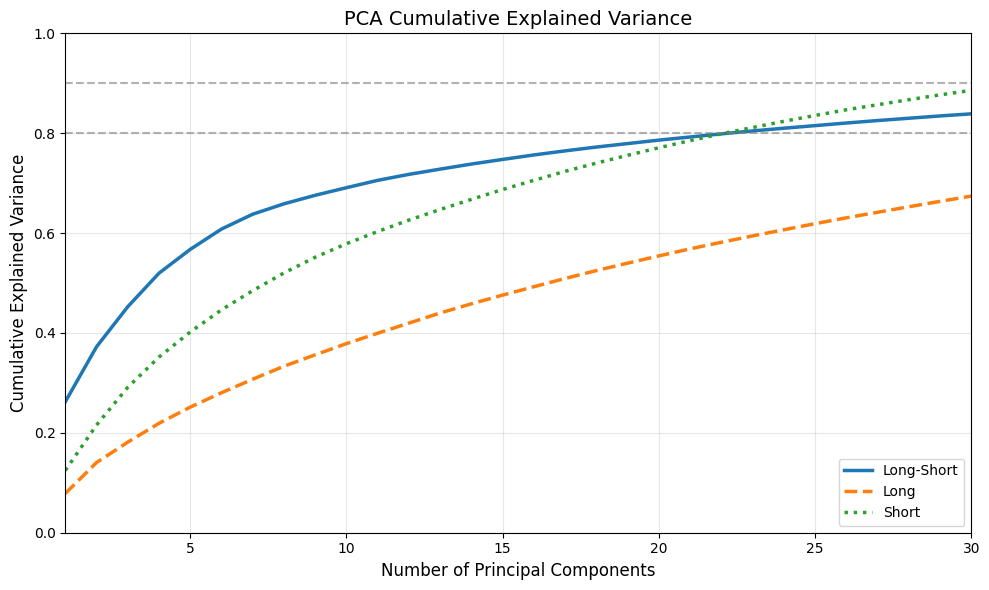

In [17]:
#Exercise 1
df_exp_var = pd.DataFrame([explained_var_long_short, explained_var_long, explained_var_short], index = ["long_short", "long", "short"]).transpose()

x = np.arange(1, len(df_exp_var) + 1)

plt.figure(figsize=(10,6))

plt.plot(x, df_exp_var["long_short"], linewidth=2.5, label="Long-Short")
plt.plot(x, df_exp_var["long"], linewidth=2.5, linestyle="--", label="Long")
plt.plot(x, df_exp_var["short"], linewidth=2.5, linestyle=":", label="Short")

plt.axhline(0.8, color="gray", linestyle="--", alpha=0.6)
plt.axhline(0.9, color="gray", linestyle="--", alpha=0.6)

plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("PCA Cumulative Explained Variance", fontsize=14)

plt.legend()
plt.grid(alpha=0.3)
plt.xlim(1, 30)   # puedes cambiar 30 si quieres zoom
plt.ylim(0,1)

plt.tight_layout()
plt.show()

In [18]:
#Exercise 2: PCA Long Short
loadings_ls = pd.DataFrame(
    pca_large_short.components_.T,
    index=df_long_short.columns
)
loadings_ls.columns = [f"PC{i+1}" for i in range(loadings_ls.shape[1])]
loadings_ls.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,-0.008744,0.024121,0.026717,0.005156,-0.019910,0.004435,-0.001517,-0.003959,0.008765,0.016609,...,0.001975,-0.000241,0.002383,-0.004593,-0.000845,0.000832,0.003117,0.001667,0.000093,-0.002177
std,0.070706,0.067018,0.066020,0.071059,0.068394,0.071108,0.071231,0.071136,0.070703,0.069274,...,0.071220,0.071247,0.071207,0.071098,0.071242,0.071242,0.071178,0.071227,0.071247,0.071214
min,-0.223134,-0.194027,-0.109747,-0.105736,-0.222788,-0.213193,-0.080937,-0.214863,-0.244430,-0.261225,...,-0.356903,-0.303042,-0.432532,-0.338093,-0.481299,-0.491802,-0.296915,-0.484624,-0.600344,-0.567282
25%,-0.028071,-0.010680,-0.009742,-0.013281,-0.059294,-0.037557,-0.017209,-0.025346,-0.014644,-0.012999,...,-0.013644,-0.015145,-0.012892,-0.012366,-0.009494,-0.007136,-0.010641,-0.009004,-0.005872,-0.005212
50%,-0.004396,0.016832,0.014594,-0.001208,-0.014157,0.003501,-0.005387,-0.005900,0.003566,0.018563,...,-0.001998,-0.001453,-0.000834,0.000264,-0.000575,0.001550,0.000327,-0.001088,0.000804,-0.000035
75%,0.013963,0.064091,0.051407,0.012624,0.005177,0.047140,0.005437,0.018246,0.024788,0.044762,...,0.012619,0.012233,0.011444,0.009620,0.007100,0.013518,0.009455,0.006414,0.007160,0.003676
max,0.290354,0.226643,0.276811,0.910983,0.236791,0.222419,0.942399,0.434969,0.614872,0.456319,...,0.427124,0.375236,0.462444,0.442492,0.567272,0.548096,0.581252,0.538664,0.632701,0.694758


In [19]:
display(loadings_ls["PC1"].sort_values(ascending=False).head(10))
display(loadings_ls["PC1"].sort_values().head(10))

BidAskSpread    0.290354
BetaFP          0.289764
Price           0.274933
Beta            0.250063
LRreversal      0.144463
STreversal      0.143004
DolVol          0.115603
Size            0.101597
MomOffSeason    0.099471
BetaTailRisk    0.095088
Name: PC1, dtype: float64

High52            -0.223134
Mom12m            -0.221294
RealizedVol       -0.209649
MaxRet            -0.202014
Mom6m             -0.199889
IdioVolAHT        -0.189851
IdioVol3F         -0.187255
MomVol            -0.185727
Mom12mOffSeason   -0.169919
std_turn          -0.124581
Name: PC1, dtype: float64

In [20]:
display(loadings_ls["PC2"].sort_values(ascending=False).head(10))
display(loadings_ls["PC2"].sort_values().head(10))

DolVol           0.226643
zerotrade6M      0.204233
zerotrade12M     0.192689
MomOffSeason     0.171682
zerotrade1M      0.169627
PriceDelayRsq    0.161207
Price            0.156288
AM               0.147186
VolMkt           0.145948
RealizedVol      0.145842
Name: PC2, dtype: float64

Mom12m            -0.194027
MomVol            -0.152562
Mom6m             -0.147277
Mom12mOffSeason   -0.143964
Cash              -0.121971
IntMom            -0.121490
Beta              -0.091095
High52            -0.087576
BetaFP            -0.086867
RD                -0.084684
Name: PC2, dtype: float64

The PCA results indicate that a relatively small number of components explain a substantial portion of the variation in the anomaly portfolios, suggesting the presence of common risk dimensions. The first principal component represents a broad risk and liquidity factor, loading positively on characteristics such as beta, size, and trading activity, and negatively on momentum-related variables. This indicates a contrast between risk/liquidity-based strategies and performance-based strategies. The second component further captures a liquidity-versus-momentum dimension, separating trading frictions from trend-following effects. However, although these components explain a large share of total variance, they do not necessarily exhibit the highest Sharpe ratios, implying that the main sources of co-movement in returns are not always the most profitable investment directions.

In [21]:
#Exercise 2: PCA Long 
loadings_large = pd.DataFrame(
    pca_large.components_.T,
    index=df_portfolio_large.columns
)
loadings_large.columns = [f"PC{i+1}" for i in range(loadings_large.shape[1])]
loadings_large.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,-0.006015,0.025346,0.025898,0.001321,-0.045368,-0.005063,0.002070,0.000259,0.011828,0.013737,...,-0.009844,-0.001401,-0.005106,0.001397,0.003808,0.002256,0.002591,0.002604,0.012681,0.006234
std,0.095155,0.091884,0.091728,0.095337,0.083749,0.095210,0.095324,0.095346,0.094603,0.094342,...,0.094832,0.095336,0.095208,0.095336,0.095270,0.095319,0.095311,0.095310,0.094491,0.095140
min,-0.267791,-0.250452,-0.165845,-0.348009,-0.242826,-0.265503,-0.291524,-0.373965,-0.291691,-0.240707,...,-0.378198,-0.294850,-0.296834,-0.332233,-0.288955,-0.305638,-0.318776,-0.252733,-0.142004,-0.296693
25%,-0.051969,-0.012224,-0.023638,-0.028775,-0.106729,-0.041803,-0.030138,-0.029889,-0.014868,-0.050221,...,-0.052562,-0.044676,-0.037812,-0.025758,-0.038972,-0.028894,-0.026703,-0.024705,-0.011887,-0.011779
50%,-0.001875,0.020998,0.008762,-0.002355,-0.028041,-0.006117,-0.001524,0.005976,0.005206,0.017653,...,-0.003246,0.002467,-0.008372,-0.000821,0.001205,-0.005083,0.008456,0.001563,0.001674,0.000309
75%,0.046386,0.048605,0.058725,0.020808,0.007011,0.034051,0.033375,0.033954,0.043106,0.070109,...,0.025390,0.031970,0.024983,0.026551,0.055148,0.031409,0.040517,0.037583,0.020688,0.018338
max,0.277802,0.449794,0.446157,0.794466,0.350815,0.469635,0.513314,0.383864,0.381940,0.254352,...,0.380697,0.294973,0.367615,0.364365,0.290362,0.340366,0.340865,0.623055,0.891410,0.845084


In [22]:
display(loadings_large["PC1"].sort_values(ascending=False).head(10))
display(loadings_large["PC1"].sort_values().head(10))

Beta            0.277802
BrandInvest     0.238415
BidAskSpread    0.235601
CompEquIss      0.222700
BookLeverage    0.208673
Herf            0.129076
ChTax           0.128595
Mom12m          0.127317
BetaTailRisk    0.123288
FirmAgeMom      0.108097
Name: PC1, dtype: float64

SP                  -0.267791
LRreversal          -0.216013
Frontier            -0.200038
PayoutYield         -0.173519
GrAdExp             -0.158773
MRreversal          -0.157296
cfp                 -0.157039
InvGrowth           -0.154648
MeanRankRevGrowth   -0.152391
NetEquityFinance    -0.147200
Name: PC1, dtype: float64

In [23]:
display(loadings_large["PC2"].sort_values(ascending=False).head(10))
display(loadings_large["PC2"].sort_values().head(10))

Mom12m                  0.449794
FirmAgeMom              0.422637
High52                  0.399082
IndMom                  0.224621
ResidualMomentum        0.193206
MomOffSeason06YrPlus    0.096793
sfe                     0.095979
roaq                    0.091487
REV6                    0.090643
RoE                     0.088883
Name: PC2, dtype: float64

Beta                -0.250452
BidAskSpread        -0.230962
BetaTailRisk        -0.165692
Frontier            -0.137292
SP                  -0.117273
MRreversal          -0.080607
cfp                 -0.065878
OrderBacklog        -0.058316
EBM                 -0.049641
MomSeason16YrPlus   -0.046471
Name: PC2, dtype: float64

The PCA results for the large-cap portfolios indicate that the first principal component captures a volatility and idiosyncratic risk dimension, loading positively on realized volatility, maximum returns, and trading-related measures, and negatively on systematic beta and balance-sheet characteristics. This suggests that variation in large-cap anomaly portfolios is largely driven by differences in volatility and trading intensity rather than extreme financial distress. The second component clearly reflects a momentum dimension, separating performance-based strategies from systematic exposure and capital structure variables. Overall, the large-cap universe exhibits a structured but relatively stable factor decomposition, dominated by volatility and momentum effects rather than distress-driven risk.

In [24]:
#Exercise 2: PCA Short
loadings_short = pd.DataFrame(
    pca_short.components_.T,
    index=df_portfolio_short.columns
)
loadings_short.columns = [f"PC{i+1}" for i in range(loadings_short.shape[1])]
loadings_short.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.019457,0.053101,0.028135,0.016776,0.002507,0.009343,0.068847,-0.000013,0.017829,0.028302,...,0.022864,-0.002096,0.024573,0.011426,0.020326,0.005026,0.007680,-0.000392,-0.008558,0.025632
std,0.141499,0.132404,0.140002,0.141848,0.142835,0.142545,0.124786,0.142857,0.141717,0.139967,...,0.140978,0.142841,0.140684,0.142390,0.141374,0.142767,0.142646,0.142857,0.142595,0.140491
min,-0.326202,-0.354706,-0.309865,-0.283350,-0.295751,-0.251705,-0.215668,-0.381689,-0.387355,-0.247588,...,-0.410117,-0.435300,-0.182585,-0.389606,-0.331832,-0.294738,-0.225642,-0.346579,-0.356209,-0.099554
25%,-0.032185,-0.012719,-0.023097,-0.036556,-0.097650,-0.099529,0.002626,-0.105882,-0.053023,-0.044235,...,-0.046638,-0.068616,-0.079379,-0.059534,-0.044907,-0.083477,-0.050416,-0.057098,-0.099778,-0.036126
50%,0.006377,0.038839,0.027395,0.002647,-0.005757,0.011717,0.064234,-0.006239,0.015297,0.000897,...,0.017299,-0.011992,-0.001941,0.009220,-0.005183,0.007871,0.001384,-0.004128,-0.013953,0.005381
75%,0.044911,0.099322,0.054398,0.033881,0.095334,0.127283,0.106420,0.064331,0.052450,0.102859,...,0.092351,0.078126,0.076130,0.077167,0.049148,0.049380,0.037290,0.061145,0.054490,0.051695
max,0.481374,0.370890,0.692790,0.436154,0.347700,0.439836,0.373664,0.427404,0.393905,0.356014,...,0.522689,0.478823,0.407610,0.391307,0.386093,0.437396,0.694598,0.584193,0.378959,0.922938


In [25]:
display(loadings_short["PC1"].sort_values(ascending=False).head(10))
display(loadings_short["PC1"].sort_values().head(10))

AM                 0.481374
BidAskSpread       0.387046
AssetGrowth        0.369856
BetaFP             0.296468
OPLeverage         0.174202
Illiquidity        0.142117
BetaLiquidityPS    0.122477
DelFINL            0.113085
DolVol             0.103497
LRreversal         0.056755
Name: PC1, dtype: float64

Mom12m                -0.326202
VolSD                 -0.225920
High52                -0.214152
OrgCap                -0.131034
std_turn              -0.123189
CoskewACX             -0.110563
BPEBM                 -0.107546
VolMkt                -0.101200
EarningsConsistency   -0.078403
GrSaleToGrOverhead    -0.054553
Name: PC1, dtype: float64

In [26]:
display(loadings_short["PC1"].sort_values(ascending=False).head(10))
display(loadings_short["PC1"].sort_values().head(10))

AM                 0.481374
BidAskSpread       0.387046
AssetGrowth        0.369856
BetaFP             0.296468
OPLeverage         0.174202
Illiquidity        0.142117
BetaLiquidityPS    0.122477
DelFINL            0.113085
DolVol             0.103497
LRreversal         0.056755
Name: PC1, dtype: float64

Mom12m                -0.326202
VolSD                 -0.225920
High52                -0.214152
OrgCap                -0.131034
std_turn              -0.123189
CoskewACX             -0.110563
BPEBM                 -0.107546
VolMkt                -0.101200
EarningsConsistency   -0.078403
GrSaleToGrOverhead    -0.054553
Name: PC1, dtype: float64

The first principal component for the short portfolios captures a dimension related to seasonal momentum, accrual-based characteristics, and liquidity risk. It loads positively on timing-related and trading-friction variables, while loading negatively on profitability and volatility measures. This suggests that the short-side factor structure is driven by clusters of underperforming and liquidity-sensitive stocks, highlighting the importance of trading frictions and timing effects in short positions.

In [27]:
#Exercise 3
factors_ls = pd.DataFrame(
    pca_large_short.transform(df_long_short.fillna(0)),
    index=df_long_short.index,
    columns=[f"PC{i+1}" for i in range(df_long_short.shape[1])]
)

factors_large = pd.DataFrame(
    pca_large.transform(df_portfolio_large.fillna(0)),
    index=df_portfolio_large.index,
    columns=[f"PC{i+1}" for i in range(df_portfolio_large.shape[1])]
)

factors_short = pd.DataFrame(
    pca_short.transform(df_portfolio_short.fillna(0)),
    index=df_portfolio_short.index,
    columns=[f"PC{i+1}" for i in range(df_portfolio_short.shape[1])]
)

sharpe_factors_ls = factors_ls.apply(lambda x: x.mean() * mth.sqrt(12)/ x.std())
sharpe_factors_large = factors_large.apply(lambda x: x.mean() * mth.sqrt(12)/ x.std())
sharpe_factors_short = factors_short.apply(lambda x: x.mean() * mth.sqrt(12)/ x.std())

In [28]:
print("Long Short")
display(sharpe_factors_ls)
print("Long")
display(sharpe_factors_large)
print("Short")
display(sharpe_factors_short)

Long Short


PC1     -2.460313e-17
PC2      3.795775e-17
PC3     -4.891082e-16
PC4      0.000000e+00
PC5     -2.019380e-16
             ...     
PC194   -7.475381e-16
PC195   -1.529204e-16
PC196   -4.917783e-16
PC197    5.261178e-16
PC198    6.523920e-16
Length: 198, dtype: float64

Long


PC1      5.147055e-16
PC2      1.448361e-16
PC3     -9.305313e-17
PC4     -3.231253e-17
PC5      7.827541e-17
             ...     
PC107   -5.173706e-16
PC108    1.172786e-16
PC109    1.388749e-17
PC110   -2.206500e-17
PC111    1.618078e-16
Length: 111, dtype: float64

Short


PC1    -1.774242e-16
PC2     0.000000e+00
PC3     1.383372e-16
PC4    -2.908352e-16
PC5    -1.398558e-16
PC6     1.009197e-16
PC7     2.167814e-16
PC8     4.748249e-17
PC9     6.946566e-17
PC10   -6.801013e-17
PC11    8.047550e-17
PC12    2.956625e-17
PC13   -5.781342e-18
PC14    1.565724e-17
PC15    1.035899e-16
PC16    1.731269e-16
PC17    2.917250e-16
PC18    3.489265e-17
PC19    2.326304e-16
PC20   -3.953122e-16
PC21    1.312533e-16
PC22    9.600897e-18
PC23    2.584517e-16
PC24   -4.063470e-16
PC25   -4.545618e-16
PC26   -1.362321e-16
PC27    4.227331e-16
PC28    2.684987e-16
PC29    2.955693e-16
PC30   -9.309339e-17
PC31    2.830288e-16
PC32    1.456334e-16
PC33   -3.060958e-16
PC34    4.574291e-16
PC35    1.299561e-16
PC36    9.224473e-17
PC37   -1.083629e-16
PC38   -6.268469e-16
PC39   -5.691694e-16
PC40   -1.170450e-16
PC41    7.773876e-18
PC42   -1.972044e-16
PC43   -3.871283e-16
PC44    6.658713e-17
PC45   -2.557830e-16
PC46    1.383337e-16
PC47   -2.312517e-16
PC48   -1.635

(b) Using the portfolio returns from `lsret.csv`, introduce an additional column corresponding to an indicator (1) for all rows.

Using all data prior to 2004 as your training/validation sample:

- Estimate lasso and ridge regressions to “predict” the indicator.
- Use the estimated coefficients to form a portfolio out-of-sample.
- Report the annualized Sharpe ratio.

In [29]:
regression_large_small = mll.run_ridge_lasso_grid_no_scaler(df_long_short)
regression_large = mll.run_ridge_lasso_grid_no_scaler(df_portfolio_large)
regression_short = mll.run_ridge_lasso_grid_no_scaler(df_portfolio_short)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: Li

In [30]:
df_sharpe_information = pd.DataFrame({"sharpe long short": [regression_large_small["ridge_sharpe"], regression_large_small["lasso_sharpe"]],
              "sharpe long": [regression_large["ridge_sharpe"], regression_large["lasso_sharpe"]],
              "sharpe short": [regression_short["ridge_sharpe"], regression_short["lasso_sharpe"]]}, index = ["ridge", "lasso"])

display(df_sharpe_information.round(2))

,sharpe long short,sharpe long,sharpe short
ridge,2.00,0.85,0.59
lasso,1.85,0.49,0.79


### (c)

For a range of latent factor counts:

- Compute PCA on the portfolio returns.
- Repeat the exercise from part (b) for each factor count.
- Plot the out-of-sample Sharpe ratio as a function of the number of factors.
- Interpret the results.

In [31]:
factors_ls.iloc[:,:5]

,PC1,PC2,PC3,PC4,PC5
date,,,,,
1926-01-30,2.647667,-1.197806,-2.990222,-0.884006,1.851687
1926-02-27,-0.354766,-3.170014,-4.147169,-1.200873,1.338898
1926-03-31,-4.505149,-3.170012,-4.565642,-1.260306,1.797387
1926-04-30,-0.932241,-3.584971,-3.939376,-1.283810,1.279877
1926-05-28,-1.717216,-2.926682,-3.937590,-1.504571,1.499862
...,...,...,...,...,...
2023-08-31,-52.641199,3.835635,7.363933,26.704158,14.764281
2023-09-29,-33.163170,7.349041,-4.601294,17.883945,5.619089
2023-10-31,-45.961683,12.352358,-13.920636,15.070385,10.925023


In [32]:
k = 5
regression_PCA_large_small = mll.run_ridge_lasso_grid_no_scaler(factors_ls.iloc[:,:k])
regression_PCA_large = mll.run_ridge_lasso_grid_no_scaler(factors_large.iloc[:,:k])
regression_PCA_short = mll.run_ridge_lasso_grid_no_scaler(factors_short.iloc[:,:k])

In [33]:
df_sharpe_PCA_information = pd.DataFrame({"sharpe PCA long short": [regression_PCA_large_small["ridge_sharpe"], regression_PCA_large_small["lasso_sharpe"]],
              "sharpe PCA long": [regression_PCA_large["ridge_sharpe"], regression_PCA_large["lasso_sharpe"]],
              "sharpe PCA short": [regression_PCA_short["ridge_sharpe"], regression_PCA_short["lasso_sharpe"]]}, index = ["ridge", "lasso"])

display(df_sharpe_PCA_information.round(2))

,sharpe PCA long short,sharpe PCA long,sharpe PCA short
ridge,-0.5,-0.38,-0.91
lasso,-0.5,-0.37,-0.92


There exists an optimal number of PCA factors that maximizes out-of-sample Sharpe. Too few factors underfit the data, while too many introduce noise and overfitting. The results highlight the importance of dimensionality control when constructing portfolios from large sets of signals.

(d) Repeat parts (b) and (c) for the large- and small-cap portfolios.

- Compare the results across the three sets of portfolios.
- Interpret the differences.

In [34]:
display(df_sharpe_information.round(2))
display(df_sharpe_PCA_information.round(2))

,sharpe long short,sharpe long,sharpe short
ridge,2.00,0.85,0.59
lasso,1.85,0.49,0.79


,sharpe PCA long short,sharpe PCA long,sharpe PCA short
ridge,-0.5,-0.38,-0.91
lasso,-0.5,-0.37,-0.92


### (e)

Finally, using everything you’ve learned up to this point and the portfolios from `lsret.csv`, attempt to form a portfolio that earns the highest possible Sharpe ratio out-of-sample.

Explain the reasoning behind your choices.

In [35]:
ridge_ls = regression_large_small["ridge_ls_ret"]
df_combo = df_long_short[df_long_short.index >= "2004-01-01"].copy()
df_combo["ridge"] = ridge_ls
df_combo = df_combo.sort_index()

warmup = 60  
train2 = df_combo.iloc[:warmup]    
test2  = df_combo.iloc[warmup:]
train2 = train2.fillna(0.0)
test2  = test2.fillna(0.0)

mu = train2.mean().values
Sigma = LedoitWolf().fit(train2.values).covariance_
w = np.linalg.solve(Sigma, mu)
w = w / np.sum(np.abs(w))

meta_ret = pd.Series(test2.values @ w, index=test2.index, name="meta_max_sharpe")
meta_sh  = meta_ret.mean() / meta_ret.std(ddof=1) * np.sqrt(12)
print("Sharpe ratio:",round(meta_sh, 2))

Sharpe ratio: 2.16


We use the Ridge long–short strategy as the core component, since it delivers the highest and most stable out-of-sample Sharpe ratio among the ML models. Ridge is preferred because L2 regularization handles multicollinearity across characteristics and improves out-of-sample stability.

To further increase the Sharpe ratio, we combine the Ridge strategy with the portfolios from lsret.csv, treating each as an investable long–short factor. We construct a maximum Sharpe portfolio using a 60-month warm-up window within the out-of-sample period. Expected returns and the covariance matrix are estimated using past data only, and we apply Ledoit–Wolf shrinkage to obtain a more stable covariance estimate.

The resulting weights are normalized to control leverage and then applied to the remaining out-of-sample period. The improvement in Sharpe ratio comes from diversification, as combining imperfectly correlated long–short strategies reduces volatility while maintaining strong expected returns.